# Ratings Data Set
The data was collected from technion course recommender site. Each row represent a rating for a course by one student, and that rating is divided into workload an difficuly of the course. Both ratings for workload and difficuly are deom 1 to 10, while in the instruction students are encouraged to use all of the scale, we will check how they did later. 
 
The dataset ia expected to be sparce since there are studenta from different facultys, and there are more then 1,000 courses, most of them are not rated.

# Loading The Data

In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 5]
ratings = pd.read_csv('https://raw.githubusercontent.com/yuvalgos/course_recommender_system/master/data_pool/ratings_data_2021feb24.csv')
ratings.sample(5)

,id,user,course,difficulty,workload,final_grade,semesters_taken,created_at,updated_at
585,614,63,315030,7.5,4.5,93.0,NaN,2021-01-04 15:33:27.724168+00:00,2021-01-04 15:33:27.724218+00:00
457,487,55,324397,1.5,1.0,NaN,NaN,2021-01-04 11:28:38.770355+00:00,2021-01-04 11:30:17.330960+00:00
461,501,53,335009,6.0,2.5,NaN,NaN,2021-01-04 11:31:28.518970+00:00,2021-01-04 11:31:28.519011+00:00
340,368,39,324983,2.0,1.0,97.0,NaN,2020-11-10 13:49:54.260994+00:00,2020-11-10 13:49:54.261027+00:00
567,596,67,234247,9.5,7.0,82.0,NaN,2021-01-04 14:57:32.886867+00:00,2021-01-04 14:57:32.886912+00:00


We will only use the four leftest fields because all the other fields are not mandatory or irrelevant. Some of the other fields may be in use in the future.

In [79]:
ratings_diff = ratings[["user", "course", "difficulty"]]
ratings_wl = ratings[["user", "course", "workload"]]
ratings_combined = ratings[["user", "course", "difficulty", "workload"]]
 
ratings_combined.sample(5)

,user,course,difficulty,workload
480,53,337403,5.0,1.5
417,42,234118,4.5,7.5
514,57,234218,6.5,8.0
353,39,236343,6.0,5.0
296,37,236001,2.0,3.0


# Inital Analysis And Visualization

## Inital Information

In [80]:
users_counts = ratings_diff["user"].value_counts()
courses_counts = ratings_diff["course"].value_counts()
print("number of ratings:", len(ratings_diff["user"]))
print("number of courses rated:", len(courses_counts))
print("number of students with ratings:", len(users_counts))
print()
 
print("mean difficulty:", ratings_diff["difficulty"].mean())
print("mean workload:", ratings_wl["workload"].mean())

number of ratings: 744
number of courses rated: 248
number of students with ratings: 59

mean difficulty: 6.084677419354839
mean workload: 5.606854838709677


## Courses

### Ratings Count

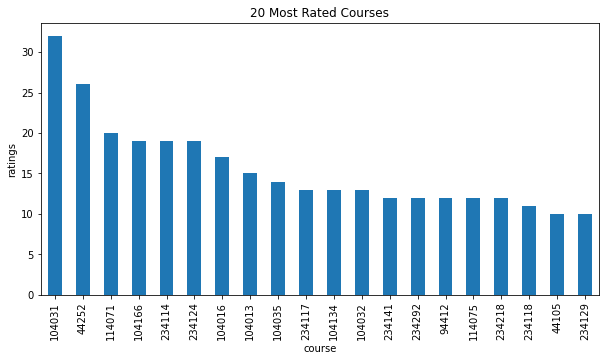

In [81]:
ax = courses_counts.iloc[0:20].plot.bar(title="20 Most Rated Courses",
                                        xlabel="course",
                                        ylabel="ratings",)

amount of courses with more then 2 ratings: 63
amount of courses with more then 5 ratings: 33
amount of courses with more then 10 ratings: 18


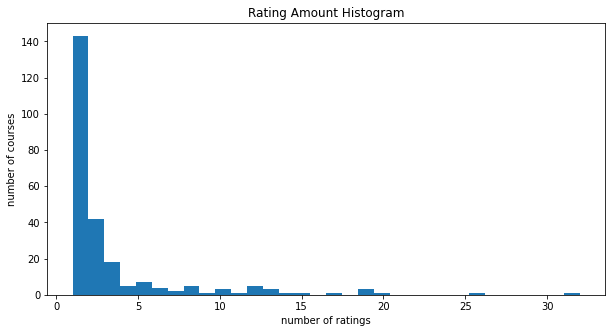

In [82]:
ax = courses_counts.plot.hist(bins=courses_counts.max(),
                              title="Rating Amount Histogram",)
ax.set_xlabel("number of ratings")
ax.set_ylabel("number of courses")
 
print("amount of courses with more then 2 ratings:",
      (courses_counts[courses_counts > 2]).count())
print("amount of courses with more then 5 ratings:",
      (courses_counts[courses_counts > 5]).count())
print("amount of courses with more then 10 ratings:",
      (courses_counts[courses_counts > 10]).count())

It seems that the majority of the qcourses has less then 5 ratings (most of them has 1) and there are few courses with high rating amount. Classic [power law](https://en.wikipedia.org/wiki/Power_law) distribution.
Because courses with one rating are not usefull, as they can't help us predict, we will remove them later.

## Average Ratings

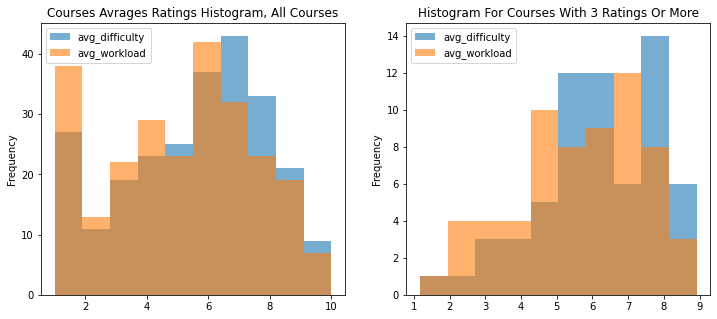

In [83]:
courses_df = courses_counts.to_frame(name="ratings_count")
courses_df["avg_difficulty"] = -1
courses_df["avg_workload"] = -1
 
for course in courses_counts.index:
    one_course_ratings = ratings_combined[ratings_combined["course"] == course]
    courses_df.loc[course, "avg_difficulty"] = one_course_ratings["difficulty"].mean()
    courses_df.loc[course, "avg_workload"] = one_course_ratings["workload"].mean()
 
fig, ax = plt.subplots(nrows=1, ncols=2)

_ = courses_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[0],
                                                        alpha=0.6,
                                                        figsize=[12,5],
                                                        title="Courses Avrages Ratings Histogram, All Courses")
# make the same plot but only for courses with moore then 2 ratings:
courses_highly_rated_df = courses_df[courses_df["ratings_count"] > 2]
_ =courses_highly_rated_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[1],
                                                                      alpha=0.6,
                                                                      title="Histogram For Courses With 3 Ratings Or More")

The courses average ratings seem to be diatributed well, especially when ignoring courses with one or two ratings.

## Students

### ratings count

students with 8 ratings or more: 37


Text(0, 0.5, 'number of users')

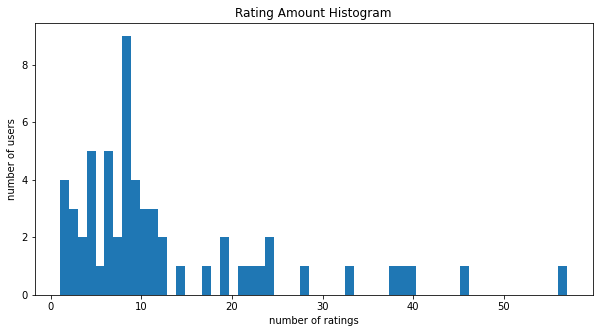

In [84]:
print("students with 8 ratings or more:", len(users_counts[users_counts >= 8]))
 
ax = users_counts.plot.hist(bins=users_counts.max(),
                              title="Rating Amount Histogram",)
ax.set_xlabel("number of ratings")
ax.set_ylabel("number of users")

A lot of students have 8 ratings because it was stated that in order to get an prediction for courses, one must have at least 8 ratings. Later we will check if  the minimum number of ratings can be lowered with out damaging the accuracy. 
 
I specificly checked the ratings of the student with 57 ratings, and they actualy make sense and not random, it's a biomedical engineering student.

In [85]:
# those calculation are for the 2 next graphs :
users_df = users_counts.to_frame(name="ratings_count")
users_df["avg_difficulty"] = -1
users_df["avg_workload"] = -1
users_df["max_difficulty"] = -1
users_df["min_difficulty"] = -1
users_df["max_workload"] = -1
users_df["min_workload"] = -1
 
for user in users_counts.index:
    one_user_ratings = ratings_combined[ratings_combined["user"] == user ]

    users_df.loc[user , "avg_difficulty"] = one_user_ratings["difficulty"].mean()
    users_df.loc[user , "avg_workload"] = one_user_ratings["workload"].mean()

    users_df.loc[user , "max_difficulty"] = one_user_ratings["difficulty"].max()
    users_df.loc[user , "min_difficulty"] = one_user_ratings["difficulty"].min()
    users_df.loc[user , "max_workload"] = one_user_ratings["workload"].max()
    users_df.loc[user , "min_workload"] = one_user_ratings["workload"].min()

users_df["ratings_range_diff"] = users_df["max_difficulty"] - users_df["min_difficulty"]
users_df["ratings_range_wl"] = users_df["max_workload"] - users_df["min_workload"]

### Average Ratings

Text(0, 0.5, 'number of students')

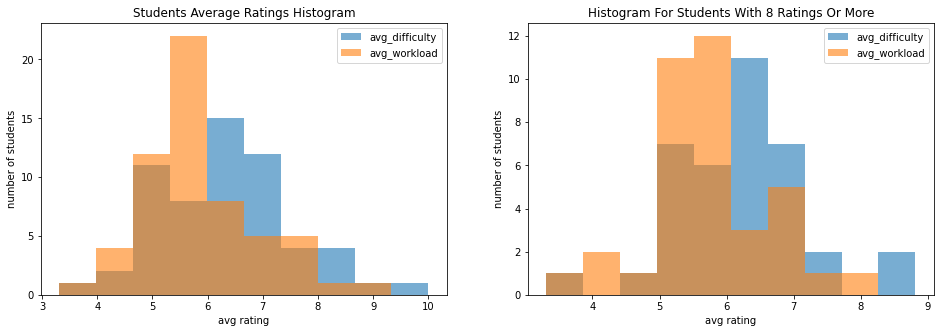

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[16,5],)

ax0 = users_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[0],
                                                        alpha=0.6,
                                                        title="Students Average Ratings Histogram")
ax0.set_xlabel("avg rating")
ax0.set_ylabel("number of students")

# make the same plot but only for users with more 8 ratings or more:
users_8_plus_df = users_df[users_df["ratings_count"] >= 8]
ax1 = users_8_plus_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[1],
                                                                      alpha=0.6,
                                                                      title="Histogram For Students With 8 Ratings Or More")
ax1.set_xlabel("avg rating")
ax1.set_ylabel("number of students")

### Ratings Range
Students are encouraged to use all the 1-10 scale in their votes in order to produce high quality data and to get better predictions. 
We are going to check how well they did, this time we only use the data of students with 8 ratings or more.
the maximum range is 9 (there is no 0 in the scale).

Text(0, 0.5, 'number of students')

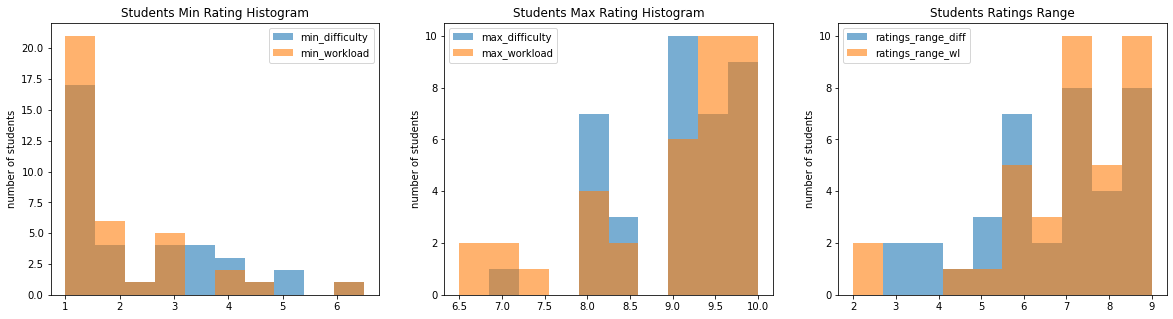

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[20,5],)

ax0 = users_8_plus_df[["min_difficulty", "min_workload"]].plot.hist(ax=ax[0],
                                                        alpha=0.6,
                                                        title="Students Min Rating Histogram")
ax0.set_ylabel("number of students")

ax1 = users_8_plus_df[["max_difficulty", "max_workload"]].plot.hist(ax=ax[1],
                                                                      alpha=0.6,
                                                                      title="Students Max Rating Histogram")
ax1.set_ylabel("number of students")

ax2 = users_8_plus_df[["ratings_range_diff", "ratings_range_wl"]].plot.hist(ax=ax[2],
                                                                      alpha=0.6,
                                                                      title="Students Ratings Range")
ax2.set_ylabel("number of students")

It seems that most of the students did well, but becasue some of the students did not use enough of the scale, we might want to normlize students ratings to 1-10 scale when performing algorithems on the data.

## Correlation Between Workload And Difficulty

In [88]:
corr = ratings_combined["workload"].corr(ratings_combined["difficulty"])
print("the correlation beetween workload and difficulty is", corr)

the correlation beetween workload and difficulty is 0.598543461791896


## Ratings Variances (And Standard Deviation)
We would also like to know what are the varicances of the courses ratings. Low variance on course ratings, means that most of the students think pretty much the same, and maybe predicting difficulty using ML algorithms is superfluous becase the average is a pretty good predictor for everyone. 
we will look at the 20 most rated courses. 

average std for difficulty: 1.4073870847942722
average std for workload: 1.3575180913270293


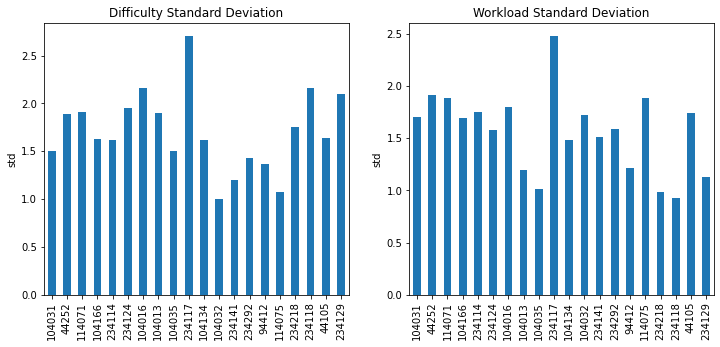

In [89]:
courses_df["var_diff"] = -1
courses_df["var_wl"] = -1

# we will calculate variance for all the courses anyway
for course in courses_df.index:
    one_course_ratings = ratings_combined[ratings_combined["course"] == course]
    variances = one_course_ratings.var()
    courses_df.loc[course, "var_diff"] = variances["difficulty"]
    courses_df.loc[course, "var_wl"] = variances["workload"]

# ignoring variance, we can get better conclution from the std
#
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12,13])
# ax1 = courses_df["var_diff"].iloc[0:20].plot.bar(ax=ax[0,0],
#                                         title="Difficulty Variance",
#                                         ylabel="variance",)
# ax2 = courses_df["var_wl"].iloc[0:20].plot.bar(ax=ax[0,1],
#                                         title="Workload Variance",
#                                         ylabel="variance",)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,5])

courses_df["std_diff"] = np.sqrt(courses_df["var_diff"])
courses_df["std_wl"] = np.sqrt(courses_df["var_wl"])

ax3 = courses_df["std_diff"].iloc[0:20].plot.bar(ax=ax[0],
                                        title="Difficulty Standard Deviation",
                                        ylabel="std",)
ax4 = courses_df["std_wl"].iloc[0:20].plot.bar(ax=ax[1],
                                        title="Workload Standard Deviation",
                                        ylabel="std",)

print("average std for difficulty:", courses_df["std_diff"].mean())
print("average std for workload:", courses_df["std_wl"].mean())

In most of the rated courses, the standad deviation is quite low: around 1.5 and there are some courses with very low value. but some courses has high variance of ratings and may be intrasting to predict for students or to be used for prediction.

234117 for example, "Introduction To Computer Science" is a first semester course which some students find hard and some easy. We could expect that student thinking this course is hard will think the same on other programming courses.



# Data Preparation
As mentioned earlier, we are not going to handle courses with one rating and at this point we are only going to handle students with less then 8 ratings (we will test this number later).

for performance reasons, our algorithms are going to work on numpy arrays and not on pandas dataframes.

The algorithms are going to get an $n$ x $2$ matrix and $n$ x $1$ vector as a training input because this is how the data is represented in our database. of course some of the algorithms are going to change the representation.

$X = \begin{pmatrix}
  u^{(1)} & c^{(1)} \\
  \vdots  & \vdots \\
  u^{(n)} & c^{(n)} 
 \end{pmatrix}$
 $ \mathbf y = \begin{pmatrix}
  y^{(1)}\\
  \vdots \\
  y^{(n)} 
 \end{pmatrix} $

each row is one rating while $u$ represents user, $c$ course and $y$ difficulty or workload. of course that for some $i \neq j $,  $u^{(i)} = u^{(j)} $ and same for course.

for prediction, the input will be **one** user and one course $\mathbf x = (u , c)$ and the out put will be an estimation for difficulty or workload $\mathbf{\hat y_{diff}}$ \ $\mathbf{\hat y_{wl}} $.

the prediction will be for one sample at a time although it may harm the perfomence when testing the algorithm here (a python function call for each sample instead of vectorized implementation), it is better for production, because at the website we are going to make one prediction at a time so we can optimize the algorithm for one prediction.






In [90]:
X_df = ratings_combined[["user", "course", "workload", "difficulty"]]
# X_df actually contains now both y vectors, they will be seperated 
# at convertion to numpy

# clean courses with less then 2 ratings:
courses_df_clean = courses_df[courses_df["ratings_count"] > 1]
X_df = X_df[X_df["course"].isin(courses_df_clean.index)]

# clean students with less then 8 ratings:
X_df = X_df[X_df["user"].isin(users_8_plus_df.index)]

print("we are left with", len(X_df), "samples")
print()

# convert to numpy:
X = X_df[["user", "course"]].to_numpy()
y_diff = X_df["difficulty"].to_numpy()
y_wl = X_df["workload"].to_numpy()

we are left with 523 samples



# Algorithm Metrics
## Defining The Problem
Given user U and course C, we would like to give an prediction for the difficulty and workload of C to U, using all the other ratings.
this is a **regression** problem.
In some cases the prediction is impossible, for example: the course U doesn't have any ratings at all. we could do something like giving a naive prediction of 5 or the mean rating in the data, but i prefer not to do that because it could harm the transparency of the metrics.
therefore, a prediction can be either a real number from 1 to 10 or a None which means the prediction was impossible.

## Metrics
We should define metrics to measure how good is a recommendation or set of recommedations.

The metrics are not going to combine difficulty and workload but be calculated for each prediction seperatly.

given a set of user ratings
 $ \mathbf{y} = \begin{pmatrix}
  y^{(1)} \\
  y^{(2)} \\
  \vdots \\
  y^{(n)}
  \end{pmatrix}$
and a set of predictions 
$\mathbf{\hat y} = \begin{pmatrix}
  \hat y^{(1)} \\
  \hat y^{(2)} \\
  \vdots \\
  \hat y^{(n)}
  \end{pmatrix}$ ,

we will define $l(y^{(i)}, \hat y^{(i)})$ as the loss function, an error function on one prediction and $E(\mathbf{y}, \mathbf{\hat y})$ as the error on the set.
<br><br>
### MAE
This is the most intuitive method. It measures the average prediction error on a set of prediction.

$l(y^{(i)}, \hat y^{(i)}) = |y^{(i)} - \hat y^{(i)}|$

$E(\mathbf{y}, \mathbf{\hat y}) = \frac{1}{n} \sum_{i=1}^n |y^{(i)} - \hat y^{(i)}| $

It is good method because it lets us know exactly the average of "how match we are wrong"
<br><br>
### RMSE
This method is very well known and widely used.
It measures the average root square error of the prediction.
$l(y^{(i)}, \hat y^{(i)}) = (y^{(i)} - \hat y^{(i)})^2$

$E(\mathbf{y}, \mathbf{\hat y}) = \frac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat y^{(i)})^2 $

Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors on the set, so optimazing the RMSE will penalize large errors.
 <br><br>

 ### 1/2 loss missclasification rate
This method uses the MAE formula but returns a binary loss. it ignores errors lower then 0.5 and counts errors higher then that.

$l(y^{(i)}, \hat y^{(i)}) = \mathbb I\{|y^{(i)} - \hat y^{(i)}| > 0.5 \} \in \{0,1\}$

$E(\mathbf{y}, \mathbf{\hat y}) = \frac{1}{n} \sum_{i=1}^n \mathbb I\{|y^{(i)} - \hat y^{(i)}| > 0.5 \} \in [0,1]$

This method is usefull because it ignores low errors. optimizing it means we are maximizing the amount of right predictions, assuming that an up to 0.5 error is negligible. 
(if a student real value of difficulty is 6.5 for example, 6 to 7 are reasonable predictions)

In [91]:
from sklearn.metrics import mean_absolute_error as mae
mae.__name__ = "mae"
from sklearn.metrics import mean_squared_error


def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))


def half_miss_rate(y, y_hat):
    """ half missclassification rate function for 2 numpy vectors """
    assert(len(y) == len(y_hat))
    loss_vector = np.absolute(y - y_hat) > 0.5
    return np.count_nonzero(loss_vector) / len(loss_vector)


assert(half_miss_rate(np.array([1,2,3]), np.array([1.3, 2.9, 3])) == 1/3)
assert(mae(np.array([1,2,3]), np.array([2, 3, 7])) == 2)
assert(rmse(np.array([1,1,1]), np.array([2, 2, 2])) == 1)

## Algorithm Evaluation
### 10-Fold For Test
Since our data is small and sparce, a simple 20-80 test-train split will not be enough. Also a 5-fold split leaves us with tarin sets which are too small and may not have enough common courses/users with the test sets. Therefore we will use 10-fold split for train set and test set. 
We can allow ourself to do that because training and testing 10 times will not take too long as the data is small.
 
For our first naive algorithms we don't need validation set becasue there are no parameters to tune, but we will make that split later.

In [92]:
from typing import Callable, List, Union
from sklearn.model_selection import KFold
 
 
# define generic algorithm for evaluator:
class GenericAlgorithm():
    def __init__(self):
        self.is_trained = False

    def train(self, X, y):
        assert(X.shape[0] == len(y))
        assert(X.shape[1] == 2)
        self.is_trained = True
 
    def predict(self, x):
        assert(len(x) == 2)
        assert(self.is_trained == True)
 
 
class AlgorithmEvaluator():
    def __init__(self,
                 num_of_folds: int, 
                 metric_functions: List[ Callable[[np.ndarray, np.ndarray], float] ]=
                                                           [mae, rmse, half_miss_rate],
                 random_seed: Union[None, int]=None):
        """
         Create algorithm evaluator that evaluate algorithms with num_of_folds
         folds and a list of metrics.
         metric_functions is list of functions, each of the function recives 
         two arrays (y and y_hat) and returns the error E.
        """
        self.metrics = metric_functions
        self.k = num_of_folds
        self.k_fold = KFold(n_splits=self.k,
                            shuffle=True,
                            random_state=random_seed)
        self.last_res = None
        
    def evaluate(self, 
                 algo :GenericAlgorithm,
                 X: np.ndarray,
                 y: np.ndarray) -> pd.DataFrame:
        """ 
        evaluate a given algorithm (with the methods train and predict), 
        returns table of the results of each fold as DataFrame
        """
        df_columns = ["fold", "n_train", "n_test", "n_was_impossible",]
        df_columns += [m.__name__ for m in self.metrics]
        res = pd.DataFrame(columns=df_columns)
 
        # itarate over folds 
        i_fold = 1  # fold counter
        for train_index, test_index in self.k_fold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
 
            algo.train(X_train, y_train)
            y_hat = np.array([algo.predict(x) for x in X_test])
 
            none_count = np.count_nonzero(y_hat == None)
            df_row = ["f" + str(i_fold), len(y_train), len(y_test), 
                      none_count]
 
            # remove none values from y and y_hat:
            numerical_indices = np.where(y_hat != None)
            y_test, y_hat = y_test[numerical_indices], y_hat[numerical_indices]
 
            df_row += [metric(y_test, y_hat) for metric in self.metrics]
 
            res.loc[i_fold] = df_row
 
            i_fold += 1
        
        # add last row as means:
        res.loc[i_fold] = res.mean()
        res.loc[i_fold, ["fold", "n_train", "n_test"]] = ["AVG", '', '']
        self.last_res = res
        return res
 
    def print_summery(self):
        print(self.last_res.iloc[self.k])

# Naive Algorithms
First, we will test some simple (and not very usefull) estimators. They are usefull for comparing to other algorithms and they results may be a good starting point to improve from.

## Course Mean 
Actualy, although this eatimator is simple, it is quite good for prediction. 
All it does in order to predict rating of user U for course C is return the mean rating of C in the data.
 
formaly:
 
$R(U,C) = \frac{1}{|R_c|} \sum_{r \in R_c} r$
 
Where $R_C$ is the set of all ratings of C.
 
By the way, here the MAE should have around the same value as the mean S.T.D of courses we computed earlier.

In [93]:
class MeanRating(GenericAlgorithm):
    def __init__(self):
        super().__init__()
        self.x = None
        self.y = None
 
    def train(self, X, y):
        super().train(X, y)
        self.x = X[:,1] # we don't need to know the user
        self.y = y
        # this is a lazy implementation, we only calculate the average when 
        # a prediction is requested
 
    def predict(self, x):
        super().predict(x)
        if not x[1] in self.x:
             return None
        return self.y[self.x == x[1]].mean()

In [94]:
evaluator = AlgorithmEvaluator(10, random_seed=69**2)
algo = MeanRating()
print("difficulty evaluation")
evaluator.evaluate(algo, X, y_diff)

difficulty evaluation


,fold,n_train,n_test,n_was_impossible,mae,rmse,half_miss_rate
1,f1,470,53,1,1.759143,2.197034,0.807692
2,f2,470,53,0,1.183508,1.404227,0.773585
3,f3,470,53,5,1.426273,1.826645,0.770833
4,f4,471,52,0,1.536732,1.989648,0.692308
5,f5,471,52,0,1.458770,1.949137,0.711538
6,f6,471,52,1,1.414885,1.834381,0.666667
7,f7,471,52,5,1.466966,1.916166,0.808511
8,f8,471,52,2,1.825707,2.198589,0.860000
9,f9,471,52,0,1.493651,1.939531,0.750000
10,f10,471,52,0,1.368560,1.755525,0.730769


In [95]:
 print("workload evaluation")
evaluator.evaluate(algo, X, y_wl)

workload evaluation


,fold,n_train,n_test,n_was_impossible,mae,rmse,half_miss_rate
1,f1,470,53,1,1.734918,2.102399,0.788462
2,f2,470,53,0,1.205206,1.636124,0.641509
3,f3,470,53,5,1.597754,2.001928,0.729167
4,f4,471,52,0,1.625904,2.104761,0.750000
5,f5,471,52,0,1.234341,1.558802,0.653846
6,f6,471,52,1,1.163747,1.568457,0.627451
7,f7,471,52,5,1.745925,2.068449,0.893617
8,f8,471,52,2,1.573862,2.104274,0.740000
9,f9,471,52,0,1.522612,1.842543,0.769231
10,f10,471,52,0,1.469208,1.811815,0.807692


The reaults for both workload and difficulty in words:
* On an average case, according to the MAE we will have around 1.5 error in prediction
* Around 1/4 of prediction are within 0.5 error according to half missclassification rate
 
Those reaults may give us reference for other algorithms.

## Dummy Five
Before we go ahead, lets try one more naive algorithm. This one is even simpler but not very usefull.
No matter what the user, or the course we are predicting, it will return 5. Formaly:
$R(U,C) = 5$

We actually already know that the MAE can't be higher then 5 here (it would have been 5 if all ratings were 10).

This time we will only show the final reault and not all the folds.

In [96]:
 class DummyFive(GenericAlgorithm): 
    def __init__(self):
        super().__init__()
 
    def train(self, X, y):
        super().train(X, y)
 
    def predict(self, x):
        super().predict(x)
        return 5

In [97]:
evaluator = AlgorithmEvaluator(10, random_seed=69**2)
algo = DummyFive()
print("dificulty evaluation")
evaluator.evaluate(algo, X, y_diff)
evaluator.print_summery()
 
print()
print("workload evaluation")
evaluator.evaluate(algo, X, y_wl)
evaluator.print_summery()

dificulty evaluation
fold                     AVG
n_train                     
n_test                      
n_was_impossible           0
mae                  2.15974
rmse                  2.5443
half_miss_rate      0.844848
Name: 11, dtype: object

workload evaluation
fold                    AVG
n_train                    
n_test                     
n_was_impossible          0
mae                 1.99064
rmse                2.37536
half_miss_rate      0.81045
Name: 11, dtype: object


# KNN
KNN stands for K Nearest Neighbors. K is a parameter for the algorithm.

In the user based version, we find the k most similar users to U that rated the course C, calculate the mean of their rating for C and return the result as the prediction.

In the item based version (in our case course based), we find the k most similar courses to C that U rated, calculate the mean of ratings by U for those courses and return the result as the prediction.


## similarity
In order to use KNN, we have to define similarity beetween two users or courses. 
For the user case, similarity is a function $ S(U_1, U_2)$ that gets 2 users and return a number that indicates how similar they are.
There are several common similarity functions like euclidean distance and manhattan distance, but the one we are going to use is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

the cosine similarity beetweeen two vectors $\mathbf{a} $ and $\mathbf{b} $ is defined : 

$S(\mathbf{a}, \mathbf{b}) 
=  \frac{\mathbf{a}^T \mathbf{b}}{||\mathbf{a}|||\bf{b}||} 
= \frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}|||\mathbf{b}||}$

It returns a number between -1 and 1 which represents the angel beetween the two vectors in space, its quite inituitive in 2D.

But what are  the vectors in the case of two users? We could create a vector for each user for his ratings, but those vectors are going to be as long as the number of courses and sparce because each user rated a small fraction of the courses. Instead, we will calculate the similarity beetween two users in the common courses space. we will create vector for each of the two user where each component is his rating for a course they both rated. So the vector length will be the amount of common courses, this number will be defined as the support. Now we can define another parameter for the algorithm, the minimal support. 1 common course may be not enough to know for sure how two users are similar, therefore we might not want to use $U_1$ to predict $U_2$. 

Formaly for the user based case : Let $R_i$ be the set of courses rated by $U_i$, and $R_{i,k}$ the rating of $U_i$ to course k. Then:

$S(U_i,U_j) = \frac{\sum_{k \in  R_i \cup R_j}R_{i,k} R_{j,k}}{\sqrt{ \sum_{k \in  R_i \cup R_j}R_{i,k}^2} \sqrt{ \sum_{k \in  R_i \cup R_j}R_{j,k}^2}}$

It is defined if $R_i \cup R_j > min\_support$

Luckily, we dont have to normalize the similarity becasue it is already normlized to [-1,1]. (well actualy to [0,1] since we dont have negative ratings (well actualy it cant be zero since we dont have a 0 rating)).

The prediction for a student and acourse is simply the mean of the k most similar users rating for this course. If there aren't students with ratings to this course who also have at least $min_support$ common courses with the predicted student, then the prediction is impossible for this algorithm.

Altough there is an efficient way to cumpute a similarity matrix that contains the similarity between every pari of users, we are not going to need it since we decided to optimize our algorithms to predict one user at a time therefore we only need a few similarities in each prediction.

In [98]:
class KNNGeneric(GenericAlgorithm): 
    def __init__(self, k=5, min_support=2):
        assert(k>=1)
        assert(min_support>=1)
        super().__init__()

        self.k = k
        self.X = None
        self.y = None
        self.min_support = min_support

    def train(self, X, y):
        super().train(X, y)
        self.X = X
        self.y = y
        # all the calculations are going to be done in predict
    
    def predict(self, x):
        super().predict(x)

### Implementation Of The User Based KNN:

In [99]:
class KNNUser(KNNGeneric): 
    def __init__(self, k=5,  min_support=2):
        super().__init__(k, min_support)

    def _cosine_similarity(self, user1, user2):
            """
            compute the cosine similarity of two users using only courses they both
            rated. in order to do that the users must have at least self.min_support
            courses they both rated, otherwise None is returned.
            """
            # find all ratings indices for each user:
            u1_ratings_ind = np.where(self.X[:, 0] == user1)[0]
            u2_ratings_ind = np.where(self.X[:, 0] == user2)[0]
            X_u1 = self.X[u1_ratings_ind, :]
            X_u2 = self.X[u2_ratings_ind, :]
            y_u1 = self.y[u1_ratings_ind]
            y_u2 = self.y[u2_ratings_ind]

            # get the common courses and their indices in each users rating array
            common_courses, u1_ind_common, u2_ind_common = np.intersect1d(X_u1[:,1],
                                                                        X_u2[:,1],
                                                                        assume_unique=True,
                                                                        return_indices=True)
            # check support is large enough:
            if not len(common_courses) >= self.min_support:
                return None

            # create vectors for each user in the common courses space:
            y_u1_common = y_u1[u1_ind_common]
            y_u2_common = y_u2[u2_ind_common]
                
            # return cosine similarity in that space:
            return np.inner(y_u1_common, y_u2_common) / (np.linalg.norm(y_u1_common)*
                                                        np.linalg.norm(y_u2_common))
            
    def predict(self, x):
        super().predict(x)
        user, course = x[0], x[1]

        if user not in X[:,0]:
            print("user", user, "has no ratings in the train set")
            return None

        # find all rating for this course and all the raters:
        course_ratings_indices = np.where(self.X[:,1] == course)
        X_course = self.X[course_ratings_indices, :][0]
        y_course = self.y[course_ratings_indices]
        users_rated_course = X_course[:, 0]
        # the useres are sorted by their location on X_course and y_course

        if len(users_rated_course) == 0:
            return None

        # compute similaritiy between predicted user and each of the users rated
        # the course
        cosine_sim_vectorized = np.vectorize(self._cosine_similarity)
        similarities = cosine_sim_vectorized(users_rated_course, user)
        
        total_neighbors = len(similarities[similarities != None])
        # print(similarities, total_neighbors)

        if total_neighbors == 0:
            # impossible to predict for this user
            return None 
        elif total_neighbors <= self.k:
            neighbors_indices = np.where(similarities != None)
        else:
            similarities[similarities == None] = -1
            neighbors_indices = np.argpartition(similarities, -self.k)[-self.k:]
            neighbors = users_rated_course[neighbors_indices]

        return y_course[neighbors_indices].mean()

Lets evaluate the algorithm with the same folds :

In [118]:
algo = KNNUser(k=5,min_support=2)
evaluator.evaluate(algo, X, y_diff)
print("difficulty:")
evaluator.print_summery()
print()

print("workload:")
evaluator.evaluate(algo, X, y_wl)
evaluator.print_summery()

difficulty:
fold                     AVG
n_train                     
n_test                      
n_was_impossible         4.2
mae                  1.47359
rmse                 1.87815
half_miss_rate      0.737527
Name: 11, dtype: object

workload:
fold                     AVG
n_train                     
n_test                      
n_was_impossible         4.2
mae                  1.47977
rmse                 1.87818
half_miss_rate      0.719359
Name: 11, dtype: object


We got a slightly better results then Mean Rating. Of course we will have to find the best parameters $k$ and $min\_support$ but we will do it soon after a few improvments. We also notice that the amount of impossible prediction is slightly higher due to the $min\_support$. Increasing the $min\_support$ wil increase the number of impossible predictions.

### Implementation Of The Item Based KNN
This time we will look for similar courses for prediction.

The item based approach works better for some application but it is not expected to work well for us. Users in our data tend to be more similar to some other user then items are to items. for example - users from the same faculty should be similar and have many neighbors.

In [124]:
class KNNCourse(KNNGeneric): 
    def __init__(self, k=5,  min_support=2):
        super().__init__(k, min_support)

    def _cosine_similarity(self, course1, course2):
            """
            compute the cosine similarity of two courses using only users rated 
            them both. in order to do that the courses must have at least self.min_support
            common users, otherwise None is returned.
            """
            # find all ratings indices for each user:
            c1_ratings_ind = np.where(self.X[:, 1] == course1)[0]
            c2_ratings_ind = np.where(self.X[:, 1] == course2)[0]
            X_c1 = self.X[c1_ratings_ind, :]
            X_c2 = self.X[c2_ratings_ind, :]
            y_c1 = self.y[c1_ratings_ind]
            y_c2 = self.y[c2_ratings_ind]

            # get the common users and their indices in each course rating array
            common_users, c1_ind_common, c2_ind_common = np.intersect1d(X_c1[:,0],
                                                                        X_c2[:,0],
                                                                        assume_unique=True,
                                                                        return_indices=True)
            # check support is large enough:
            if not len(common_users) >= self.min_support:
                return None

            # create vectors for each course in the common users space:
            y_c1_common = y_c1[c1_ind_common]
            y_c2_common = y_c2[c2_ind_common]
                
            # return cosine similarity in that space:
            return np.inner(y_c1_common, y_c2_common) / (np.linalg.norm(y_c1_common)*
                                                        np.linalg.norm(y_c2_common))
            
    def predict(self, x):
        super().predict(x)
        user, course = x[0], x[1]

        if course not in X[:,1]:
            print("course", course, "has no ratings in the train set")
            return None

        # find all ratings by this user and all the courses he rated:
        user_ratings_indices = np.where(self.X[:,0] == user)
        X_user = self.X[user_ratings_indices, :][0]
        y_user = self.y[user_ratings_indices]
        courses_rated_by_user = X_user[:, 1]
        # the courses are sorted by their location on X_user and y_user

        if len(courses_rated_by_user) == 0:
            return None

        # compute similaritiy between predicted course and each of the courses 
        # rated by the user
        cosine_sim_vectorized = np.vectorize(self._cosine_similarity)
        similarities = cosine_sim_vectorized(courses_rated_by_user, course)

        total_neighbors = len(similarities[similarities != None])

        if total_neighbors == 0:
            # impossible to predict for this user
            return None 
        elif total_neighbors <= self.k:
            neighbors_indices = np.where(similarities != None)
        else:
            similarities[similarities == None] = -1
            neighbors_indices = np.argpartition(similarities, -self.k)[-self.k:]
            # neighbors = courses_rated_by_user[neighbors_indices]

        return y_user[neighbors_indices].mean()

In [136]:
algo = KNNCourse(k=3, min_support=2)
print("difficulty:")
evaluator.evaluate(algo, X, y_diff)
evaluator.print_summery()
print()

print("workload:")
evaluator.evaluate(algo, X, y_wl)
evaluator.print_summery()

difficulty:
fold                     AVG
n_train                     
n_test                      
n_was_impossible        11.6
mae                  1.97308
rmse                 2.43662
half_miss_rate      0.813333
Name: 11, dtype: object

workload:
fold                     AVG
n_train                     
n_test                      
n_was_impossible        11.6
mae                  2.05835
rmse                 2.53287
half_miss_rate      0.844673
Name: 11, dtype: object


We got poor results, just a little bit better then DummyFive and even worse then CourseMean. So we will stick with user based and try to improve it.

#TODO
 
more:
 

* weighted knn
* choosing k?
* normalize ratings?
* in knn - maybe define a number of "min support" or use a weighted avrage of the support and nean based on support size
* add bagging
